In [74]:
from glob import glob
import os as os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf



Load images from folder


In [2]:
CLASS_NAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [75]:
from cv2 import cvtColor


CLASS_NAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

def augImg(img):
    flipped = cv2.flip(img, 1) # horizontal flip
    return flipped
def skew(img):
    rows, cols, ch = img.shape
    pts1 = np.float32([[50,50],[200,50],[50,200]])
    pts2 = np.float32([[10,100],[200,50],[100,250]])
    M = cv2.getAffineTransform(pts1,pts2)
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst
def load_images_from_folder(folder, augment=True):
    images, labels = [], []
    for label, className in enumerate(CLASS_NAMES):
        class_folder = os.path.join(folder, className)
        for filename in os.listdir(class_folder):
            img = cv2.imread(os.path.join(class_folder, filename))
            if img is None:
                continue
            img = cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(label)
            if augment:
                images.append(augImg(img))
                labels.append(label)
                images.append(skew(img))
                labels.append(label)
                cropped = tf.image.central_crop(img, central_fraction=0.5).numpy()
                cropped = cv2.resize(cropped, (128, 128))
                images.append(cropped)
                labels.append(label)
    return np.array(images), np.array(labels)

In [76]:
X_train, y_train = load_images_from_folder('intel-image-classification/seg_train/seg_train/', augment=True)
X_test, y_test = load_images_from_folder('intel-image-classification/seg_test/seg_test/', augment=False)

In [77]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(56136, 128, 128, 3) (56136,)
(3000, 128, 128, 3) (3000,)


Henter Short data

In [78]:
data_mengde = 10

# bruk kun 1 av 10 bilder
train_sel = np.arange(0, len(X_train), data_mengde)
test_sel = np.arange(0, len(X_test), data_mengde)
X_train_short = X_train[train_sel]
y_train_short = y_train[train_sel]
X_test_short = X_test[test_sel]
y_test_short = y_test[test_sel]

print("Brukte "+ str(round(100/data_mengde, 2)) +"% av dataen")
print(X_train_short.shape, y_train_short.shape)
print(X_test_short.shape, y_test_short.shape)

Brukte 10.0% av dataen
(5614, 128, 128, 3) (5614,)
(300, 128, 128, 3) (300,)


In [79]:
print(X_train_short.shape, y_train_short.shape)
print(X_test_short.shape, y_test_short.shape)

(5614, 128, 128, 3) (5614,)
(300, 128, 128, 3) (300,)


In [62]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
tf.keras.utils.set_random_seed(42)


bruker 31 min 30 sek, 78,8% acc på 50% av dataen

In [ ]:


X_train_img = X_train_short.astype("float32") / 255.0
X_test_img = X_test_short.astype("float32") / 255.0

cnn_model = models.Sequential(
    [
        layers.Input(shape=(128, 128, 3)),
        layers.Conv2D(32, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(len(CLASS_NAMES), activation="softmax"),
    ]
)

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

early_stop = callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

history = cnn_model.fit(
    X_train_img,
    y_train_short,
    epochs=15,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0,
)

test_loss, test_acc = cnn_model.evaluate(X_test_img, y_test_short, verbose=0)
print(f"CNN test accuracy: {test_acc:.4f}")


CNN test accuracy: 0.7880


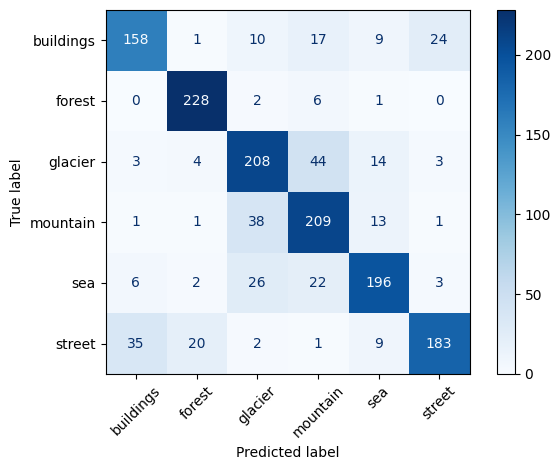

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(cnn_model.predict(X_test_img, verbose=0), axis=1)
cm = confusion_matrix(y_test_short, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.tight_layout()
plt.show()


In [80]:
def build_cnn_model(
    learning_rate=1e-3,
    dropout_rate=0.4,
    filters=(32, 64, 128),
    dense_units=256,
):
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Input(shape=(128, 128, 3)),
            tf.keras.layers.Conv2D(filters[0], (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(filters[1], (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(filters[2], (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(dense_units, activation="relu"),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


In [81]:
import itertools
import numpy as np

In [82]:
X_train_img = X_train_short.astype("float32") / 255.0
X_test_img = X_test_short.astype("float32") / 255.0


learning_rates = [1e-2, 1e-3, 5e-4]
dropout_rates = [0.3, 0.4, 0.5]
batch_sizes = [32, 64]

filter_options = [(32, 64, 128), (64, 128, 256)]
dense_options = [128, 256]

best_val_acc = -np.inf
best_params = None
best_model = None

for lr, dr, bs, fo, do in itertools.product(learning_rates, dropout_rates, batch_sizes, filter_options, dense_options):
    print(f"Tester lr={lr}, dropout={dr}, batch_size={bs}, filters={fo}, dense_units={do}")

    model = build_cnn_model(
        learning_rate=lr,
        dropout_rate=dr,
        filters=fo,
        dense_units=do,
    )

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
        restore_best_weights=True,
    )

    history = model.fit(
        X_train_img,
        y_train_short,
        epochs=8,            #denne kan justeres, holder den kort nå under trening
        batch_size=bs,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
    )

    val_acc = max(history.history["val_accuracy"])
    print(f" -> val_accuracy={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = {"lr": lr, "dropout": dr, "batch_size": bs}
        best_model = model  # beholder best weights

print("Beste kombinasjon:", best_params, "med val_accuracy:", best_val_acc)


Tester lr=0.01, dropout=0.3, batch_size=32, filters=(32, 64, 128), dense_units=128
 -> val_accuracy=0.0000
Tester lr=0.01, dropout=0.3, batch_size=32, filters=(32, 64, 128), dense_units=256


KeyboardInterrupt: 

In [73]:
test_loss, test_acc = best_model.evaluate(X_test_img, y_test_short, verbose=0)
print(f"Best CNN test accuracy: {test_acc:.4f}")


Best CNN test accuracy: 0.7100


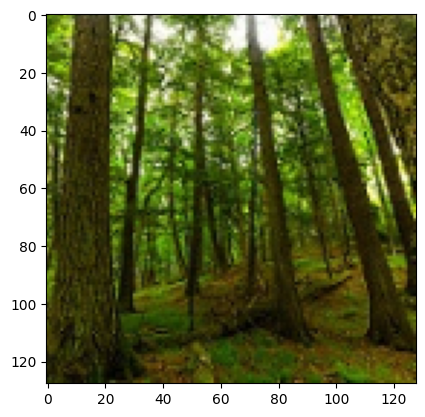

In [65]:
my_img = X_train[13000]
plt.imshow(my_img)


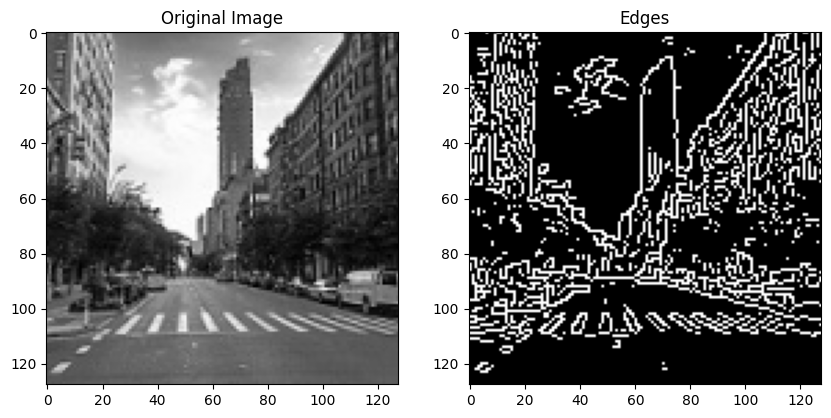

In [7]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.cvtColor(my_img, cv2.COLOR_RGB2GRAY)

# Apply Canny edge detector
edges = cv2.Canny(image, 128, 128)

# Display the original image and the edges
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Edges')
plt.imshow(edges, cmap='gray')
plt.show()

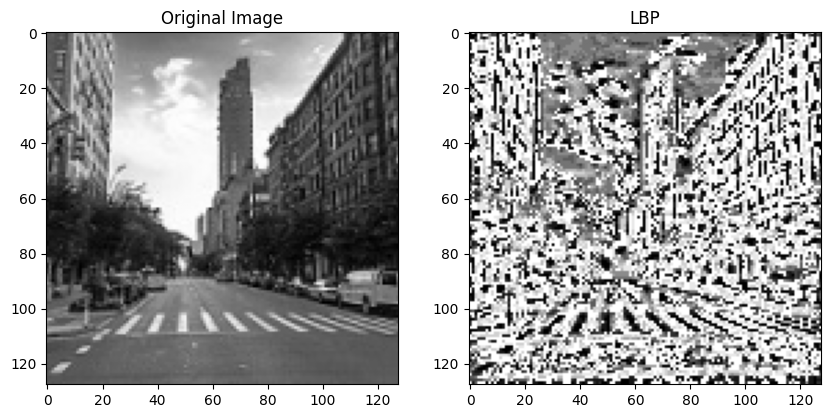

In [8]:
from skimage import io, feature
import matplotlib.pyplot as plt


# Apply Local Binary Pattern (LBP)
lbp = feature.local_binary_pattern(image, P=10, R=3, method='uniform')

# Display the original image and the LBP result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('LBP')
plt.imshow(lbp, cmap='gray')
plt.show()

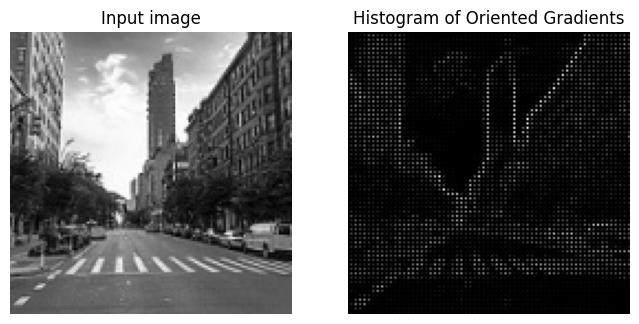

In [9]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import exposure

image = cv2.cvtColor(my_img, cv2.COLOR_RGB2GRAY)

fd, hog_image = hog(
    image,
    orientations=16,
    pixels_per_cell=(2, 2),
    cells_per_block=(8, 8),
    visualize=True,
    channel_axis=None,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
# hog_image_rescaled = exposure.rescale_intensity(hog_image)

ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [4]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from tqdm import tqdm


def extract_features(batch):
    feats = []
    for img in tqdm(batch, desc="Extracting features"):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        fd, _ = hog(
            gray,
            orientations=16,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
            channel_axis=None,
        )

        # edges = cv2.Canny(gray, 128, 128).flatten().astype(np.float32) / 255.0

        lbp = local_binary_pattern(gray, P=10, R=3, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 2), density=True)

        # feats.append(np.concatenate([fd, edges, lbp_hist]))
        feats.append(np.concatenate([fd, lbp_hist]))

    return np.asarray(feats, dtype=np.float32)

X_train_feats = extract_features(X_train)
X_test_feats = extract_features(X_test)
y_train_feats = y_train.copy()
y_test_feats = y_test.copy()

Extracting features: 100%|██████████| 3000/3000 [01:49<00:00, 27.39it/s]


In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Bruker ca 6 min

In [ ]:


clf = RandomForestClassifier(random_state=42, max_depth=None, n_estimators=300, min_samples_split=5)


clf.fit(X_train_feats, y_train)
print("Training accuracy: ", accuracy_score(y_train, clf.predict(X_train_feats)))
print("Test accuracy: ", accuracy_score(y_test, clf.predict(X_test_feats)))






Training accuracy:  0.9992874447769702
Test accuracy:  0.6706666666666666


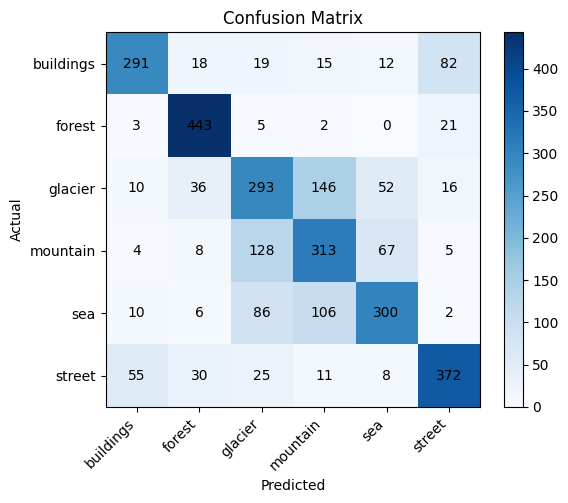

0.6706666666666666


In [8]:
y_pred = clf.predict(X_test_feats)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks(range(len(CLASS_NAMES)))
ax.set_yticks(range(len(CLASS_NAMES)))
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha="right")
ax.set_yticklabels(CLASS_NAMES)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()
print(accuracy_score(y_test, y_pred))

In [9]:
print(accuracy_score(y_test, y_pred))

0.6706666666666666


XGBoost

In [68]:
# ...existing code...
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    objective="multi:softmax",
    num_class=len(CLASS_NAMES),
    max_depth=8,
    n_estimators=400,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=42,
)
xgb_clf.fit(X_train_feats, y_train_feats)

xgb_pred = xgb_clf.predict(X_test_feats)
print(classification_report(y_test_feats, xgb_pred, target_names=CLASS_NAMES))
print(confusion_matrix(y_test_feats, xgb_pred))
print("XGB accuracy:", accuracy_score(y_test_feats, xgb_pred))

KeyboardInterrupt: 

generere short data

In [20]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from tqdm import tqdm


def extract_features(batch):
    feats = []
    for img in tqdm(batch, desc="Extracting features"):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        fd, _ = hog(
            gray,
            orientations=16,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
            channel_axis=None,
        )

        # edges = cv2.Canny(gray, 128, 128).flatten().astype(np.float32) / 255.0

        lbp = local_binary_pattern(gray, P=10, R=3, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 2), density=True)

        # feats.append(np.concatenate([fd, edges, lbp_hist]))
        feats.append(np.concatenate([fd, lbp_hist]))

    return np.asarray(feats, dtype=np.float32)

X_train_short_feats = extract_features(X_train_short)
X_test_short_feats = extract_features(X_test_short)
y_train_short_feats = y_train_short.copy()
y_test_short_feats = y_test_short.copy()

Extracting features:   0%|          | 0/2807 [00:00<?, ?it/s]

Extracting features: 100%|██████████| 600/600 [00:47<00:00, 12.67it/s]


In [17]:
clf_short = RandomForestClassifier(random_state=42, max_depth=None, n_estimators=300, min_samples_split=5)


clf_short.fit(X_train_short_feats, y_train_short)
print("Training accuracy: ", accuracy_score(y_train_short, clf_short.predict(X_train_short_feats)))
print("Test accuracy: ", accuracy_score(y_test_short, clf_short.predict(X_test_short_feats)))

Training accuracy:  1.0
Test accuracy:  0.625


XGBoost på short_data

In [26]:
# ...existing code...
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    objective="multi:softmax",
    num_class=len(CLASS_NAMES),
    max_depth=8,
    n_estimators=400,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=42,
)
xgb_clf.fit(X_train_short_feats, y_train_short)

xgb_pred = xgb_clf.predict(X_test_short_feats)
print(classification_report(y_test_short, xgb_pred, target_names=CLASS_NAMES))
print(confusion_matrix(y_test_short, xgb_pred))
print("XGB accuracy:", accuracy_score(y_test_short, xgb_pred))

              precision    recall  f1-score   support

   buildings       0.81      0.68      0.74        88
      forest       0.81      0.93      0.86        95
     glacier       0.55      0.57      0.56       110
    mountain       0.54      0.57      0.55       105
         sea       0.68      0.63      0.65       102
      street       0.76      0.74      0.75       100

    accuracy                           0.68       600
   macro avg       0.69      0.69      0.69       600
weighted avg       0.68      0.68      0.68       600

[[60  0  6  4  2 16]
 [ 0 88  4  0  0  3]
 [ 3  9 63 23 10  2]
 [ 2  2 26 60 14  1]
 [ 1  1 11 24 64  1]
 [ 8  9  4  1  4 74]]
XGB accuracy: 0.6816666666666666


In [21]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import LinearSVC



svm = LinearSVC(C=1, max_iter=10000)
svm.fit(X_train_short_feats, y_train_short)

y_pred = svm.predict(X_test_short_feats)
print("LinearSVC test accuracy:", accuracy_score(y_test_short, y_pred))

LinearSVC test accuracy: 0.6166666666666667


In [22]:
from sklearn.model_selection import StratifiedKFold

STACKING

In [ ]:


# def Stacking(model,train,y,test,n_fold):
#  folds=StratifiedKFold(n_splits=n_fold)
#  test_pred=np.empty((test.shape[0],1),float)
#  train_pred=np.empty((0,1),float)
#  for train_indices,val_indices in folds.split(train,y.values):
#     x_train,x_val=train.iloc[train_indices],train.iloc[val_indices]
#     y_train,y_val=y.iloc[train_indices],y.iloc[val_indices]
#     model.fit(X=x_train,y=y_train)
#     train_pred=np.append(train_pred,model.predict(x_val))
#     test_pred=np.append(test_pred,model.predict(test))
#  return test_pred.reshape(-1,1),train_pred

Model 1 for stacking basert på random forest short

In [ ]:
# X_train_short_df = pd.DataFrame(X_train_short_feats)
# X_test_short_df = pd.DataFrame(X_test_short_feats)
# y_train_short_s = pd.Series(y_train_short)
# y_test_short_s = pd.Series(y_test_short)

In [ ]:


# test_pred1 ,train_pred1= Stacking(model=clf_short,n_fold=5, train=X_train_short_df,test=X_test_short_df,y=y_train_short_s)

In [ ]:
# train_pred1=pd.DataFrame(train_pred1)
# test_pred1=pd.DataFrame(test_pred1)


In [ ]:
# test_pred1.head

<bound method NDFrame.head of                   0
0      0.000000e+00
1     6.952446e-310
2     1.169947e-320
3               NaN
4     6.952446e-310
...             ...
1795   5.000000e+00
1796   0.000000e+00
1797   5.000000e+00
1798   5.000000e+00
1799   5.000000e+00

[1800 rows x 1 columns]>

In [ ]:
# train_pred1.head

<bound method NDFrame.head of         0
0     4.0
1     0.0
2     0.0
3     0.0
4     0.0
...   ...
1399  1.0
1400  5.0
1401  1.0
1402  5.0
1403  5.0

[1404 rows x 1 columns]>

Model 2 for stacking basert på svm short

In [ ]:
# test_pred2 ,train_pred2= Stacking(model=svm,n_fold=5,train=X_train_short_df,test=X_test_short_feats,y=y_train_short_s)


In [ ]:
# train_pred2=pd.DataFrame(train_pred2)
# test_pred2=pd.DataFrame(test_pred2)

In [ ]:
# test_pred2.head

<bound method NDFrame.head of                   0
0     2.470328e-323
1      0.000000e+00
2     2.470328e-323
3     1.976263e-323
4      0.000000e+00
...             ...
1795   5.000000e+00
1796   0.000000e+00
1797   5.000000e+00
1798   5.000000e+00
1799   5.000000e+00

[1800 rows x 1 columns]>

In [ ]:
# train_pred2.head

<bound method NDFrame.head of         0
0     4.0
1     5.0
2     5.0
3     0.0
4     0.0
...   ...
1399  1.0
1400  5.0
1401  5.0
1402  5.0
1403  5.0

[1404 rows x 1 columns]>

In [ ]:
# y_train_short_s.head

<bound method NDFrame.head of 0       0
1       0
2       0
3       0
4       0
       ..
1399    5
1400    5
1401    5
1402    5
1403    5
Length: 1404, dtype: int64>

In [11]:
from sklearn.linear_model import LogisticRegression


In [ ]:
# df = pd.concat([train_pred1, train_pred2], axis=1)
# df_test = pd.concat([test_pred1, test_pred2], axis=1)

In [ ]:
# df_test.head

<bound method NDFrame.head of                   0              0
0      0.000000e+00  2.470328e-323
1     6.952446e-310   0.000000e+00
2     1.169947e-320  2.470328e-323
3               NaN  1.976263e-323
4     6.952446e-310   0.000000e+00
...             ...            ...
1795   5.000000e+00   5.000000e+00
1796   0.000000e+00   0.000000e+00
1797   5.000000e+00   5.000000e+00
1798   5.000000e+00   5.000000e+00
1799   5.000000e+00   5.000000e+00

[1800 rows x 2 columns]>

In [ ]:
# print(df.head)
# print("----")
# y_test_short_s.head

<bound method NDFrame.head of         0    0
0     4.0  4.0
1     0.0  5.0
2     0.0  5.0
3     0.0  0.0
4     0.0  0.0
...   ...  ...
1399  1.0  1.0
1400  5.0  5.0
1401  1.0  5.0
1402  5.0  5.0
1403  5.0  5.0

[1404 rows x 2 columns]>
----


<bound method NDFrame.head of 0      0
1      0
2      0
3      0
4      0
      ..
295    5
296    5
297    5
298    5
299    5
Length: 300, dtype: int64>

In [ ]:
# model = LogisticRegression(random_state=42, max_iter=1000)
# model.fit(df,y_train_short_s)
# model.score(df_test, y_test_short_s)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Bedre stacking :)


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


In [22]:
rf_base = RandomForestClassifier(
    random_state=42,
    max_depth=None,
    n_estimators=300,
    min_samples_split=5,
)

In [23]:
from sklearn.svm import LinearSVC

In [24]:
svm_base = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("svm", LinearSVC(C=1, max_iter=10000)),
    ]
)

In [25]:

meta_model = LogisticRegression(random_state=42, max_iter=2000)

stacking_clf = StackingClassifier(
    estimators=[("rf", rf_base), ("svm", svm_base)],
    final_estimator=meta_model,
    stack_method="auto",
    passthrough=False,
    cv=5,
    n_jobs=-1,
)

stacking_clf.fit(X_train_short_feats, y_train_short)
stack_pred = stacking_clf.predict(X_test_short_feats)

print("Stacking train accuracy:", stacking_clf.score(X_train_short_feats, y_train_short))
print("Stacking test accuracy :", accuracy_score(y_test_short, stack_pred))
print(classification_report(y_test_short, stack_pred, target_names=CLASS_NAMES))

Stacking train accuracy: 1.0
Stacking test accuracy : 0.6566666666666666
              precision    recall  f1-score   support

   buildings       0.80      0.69      0.74        88
      forest       0.84      0.89      0.87        95
     glacier       0.50      0.56      0.53       110
    mountain       0.52      0.56      0.54       105
         sea       0.66      0.53      0.59       102
      street       0.70      0.73      0.72       100

    accuracy                           0.66       600
   macro avg       0.67      0.66      0.66       600
weighted avg       0.66      0.66      0.66       600

